# Automated Smile Detection Part 2: Preprocess & Modeling
This second notebook will walk through data preparation and initial modeling. The original dataset was downloaded from this [repo](https://github.com/hromi/SMILEsmileD). It consists of 3,690 images of smiling faces and 9,476 images of non-smiling faces.  

# Imports

In [89]:
import os

import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%load_ext blackcellmagic

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


# EDA  
Read in some sample images from smiles and non-smiles.

In [76]:
pos_imgs = os.listdir("data/train/positive")
pos_imgs = [os.path.join("data/train/positive", img) for img in pos_imgs]
pos_subset = pos_imgs[0:9]
pos_subset[0]

'data/train/positive/63.jpg'

In [77]:
neg_imgs = os.listdir("data/train/negative")
neg_imgs = [os.path.join("data/train/negative", img) for img in neg_imgs]
neg_subset = neg_imgs[0:9]
neg_subset[0]

'data/train/negative/9733.jpg'

## Process Images with OpenCV

In [78]:
def process_imgs(imgs: list) -> list:
    processed_imgs = [cv2.imread(img) for img in imgs]
    return processed_imgs

### Positive Samples  
Below is a 3x3 grid of sample images from the positive training set.

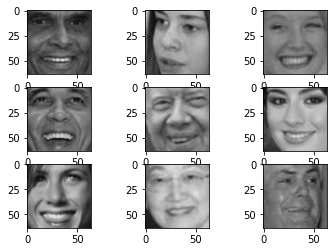

In [79]:
pos_subset_processed = process_imgs(pos_subset)

fig, axs = plt.subplots(nrows=3, ncols=3)
axs = axs.flatten()

for i, ax in enumerate(axs):
    ax.imshow(pos_subset_processed[i])
    
plt.show()

### Negative Samples  
Below is a 3x3 grid of sample images from the negative training set.

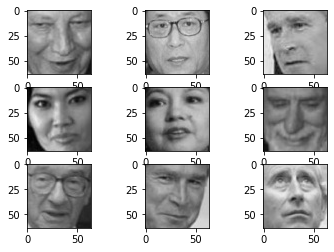

In [80]:
neg_subset_processed = process_imgs(neg_subset)

fig, axs = plt.subplots(nrows=3, ncols=3)
axs = axs.flatten()

for i, ax in enumerate(axs):
    ax.imshow(neg_subset_processed[i])
    
plt.show()

### Image Shape  
All of the images are grey-scale and consist of the following shape:

In [81]:
pos_subset_processed[0].shape

(64, 64, 3)

Based on the shape of the images, I won't have to perform any size reduction during model preprocessing.

# Modeling  
The first modeling attempt will be made with the keras module embedded in tensforflow. Depending on model performance, AutoML tools may be tested (i.e. GCP AutoML Vision & AWS Sagemaker)

In [85]:
train_dir = "data/train"
test_dir = "data/test"
val_dir = "data/validation"

In [87]:
train_datagen = ImageDataGenerator(rescale=1.0 / 255)
val_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir, batch_size=20, class_mode="binary"
)

val_generator = val_datagen.flow_from_directory(
    val_dir, batch_size=20, class_mode="binary"
)

Found 5380 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [93]:
def build_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(64, 64, 1)))
    model.add(layers.MaxPool2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation="relu"))
    model.add(layers.Dense(1, activation="sigmoid"))

    model.compile(
        loss="binary_crossentropy",
        optimizer=optimizers.RMSprop(lr=1e-4),
        metrics=["acc"],
    )
    return model

In [94]:
model = build_model()

In [96]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 128)         1

In [97]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50,
)